#Research Assignment Modularity on the Karate Club Graph

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms.community.quality import modularity

Spectral Split Function  
This function computes:

1. The **modularity matrix B**
2. Its **eigendecomposition**
3. The **leading eigenvector**
4. Splits nodes by sign of eigenvector entries  
   - `v >= 0 → community 1`  
   - `v < 0 → community 2`

In [2]:
def spectral_split(Graph):
    B = nx.modularity_matrix(Graph)
    vals, vecs = np.linalg.eigh(B) #.toarray())
    leading = vecs[:, np.argmax(vals)]
    communities_1 = {n for n, v in zip(Graph.nodes(), leading) if v >= 0}
    communities_2 = set(Graph.nodes()) - communities_1
    return communities_1, communities_2

Recursive Partitioning  
This function:

- Splits communities until:
  - Size ≤ `min_size`  
  - Or no valid split exists  
- Stores **history** → snapshot of partitions at each recursion level

In [3]:
def recursive_partition(Graph, min_size=5):
    partitions = []
    history = []   # to capture partitions at each iteration

    def recursive(nodes):
        if len(nodes) <= min_size:
            partitions.append(set(nodes))
            history.append([set(p) for p in partitions])
            return

        subG = Graph.subgraph(nodes)
        com1, com2 = spectral_split(subG)

        # stop if no real split
        if len(com1) == 0 or len(com2) == 0:
            partitions.append(set(nodes))
            history.append([set(p) for p in partitions])
            return

        # remove old block, add two refined blocks
        partitions.append(com1)
        partitions.append(com2)
        # remove the original block
        if set(nodes) in partitions:
            partitions.remove(set(nodes))

        history.append([set(p) for p in partitions])

        # recurse further
        recursive(com1)
        recursive(com2)

    recursive(set(Graph.nodes()))
    return partitions, history


Metric Computation  
For every iteration in `history`, compute **mean per-community** values of:  
- Degree centrality  
- Betweenness centrality  
- Closeness centrality  
- Clustering coefficient  

In [4]:
def compute_metrics(Graph, parts_list):
    metrics_over_time = []

    for parts in parts_list:
        metrics = {}

        # compute centralities on original graph
        deg = nx.degree_centrality(Graph)
        bet = nx.betweenness_centrality(Graph)
        clo = nx.closeness_centrality(Graph)
        clus = nx.clustering(Graph)

        # aggregate metrics per community (mean)
        community_stats = []
        for comm in parts:
            nodes = list(comm)
            community_stats.append({
                "size": len(nodes),
                "degree": np.mean([deg[n] for n in nodes]),
                "betweenness": np.mean([bet[n] for n in nodes]),
                "closeness": np.mean([clo[n] for n in nodes]),
                "clustering": np.mean([clus[n] for n in nodes]),
            })

        metrics["communities"] = community_stats
        metrics_over_time.append(metrics)

    return metrics_over_time


Plotting Functions  
**Community Visualization**

Colors each discovered community differently.


**Metric Evolution**  
Shows how average metrics change with recursion depth.

In [6]:
def plot_partition(Graph, parts, title, pos):
    plt.figure(figsize=(7,6))

    colors = plt.cm.tab20(np.linspace(0, 1, len(parts)))
    node_color = {}

    for color, comm in zip(colors, parts):
        for n in comm:
            node_color[n] = color

    nx.draw(
        Graph, pos,
        node_color=[node_color[n] for n in Graph.nodes()],
        with_labels=True, node_size=500, font_size=10
    )
    plt.title(title)
    plt.show()

 # plot metric evolution (mean across communities)
def plot_metric(metric_name):
    values = []
    for m in metrics_over_time:
        avg = np.mean([c[metric_name] for c in m["communities"]])
        values.append(avg)

    plt.figure(figsize=(7,4))
    plt.plot(range(1, len(values)+1), values, marker='o')
    plt.title(f"Evolution of {metric_name}")
    plt.xlabel("Iteration")
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.show()

 Run Partitioning + Plotting Everything  

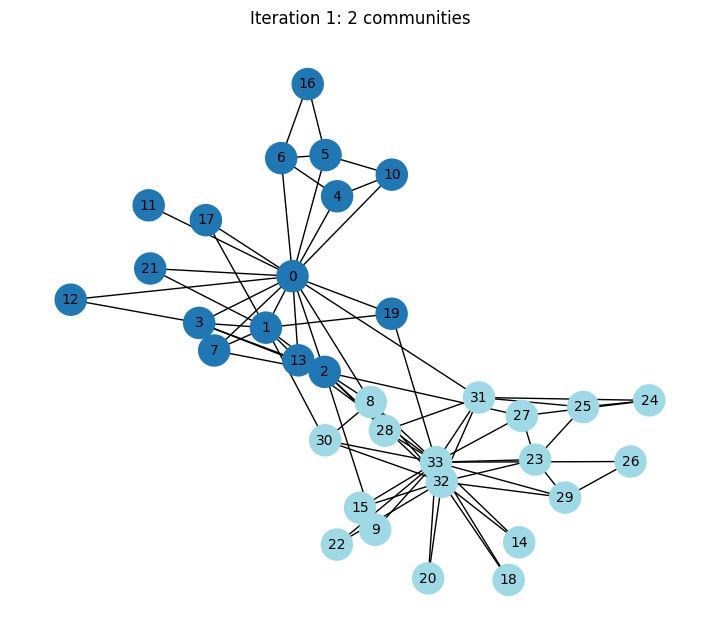

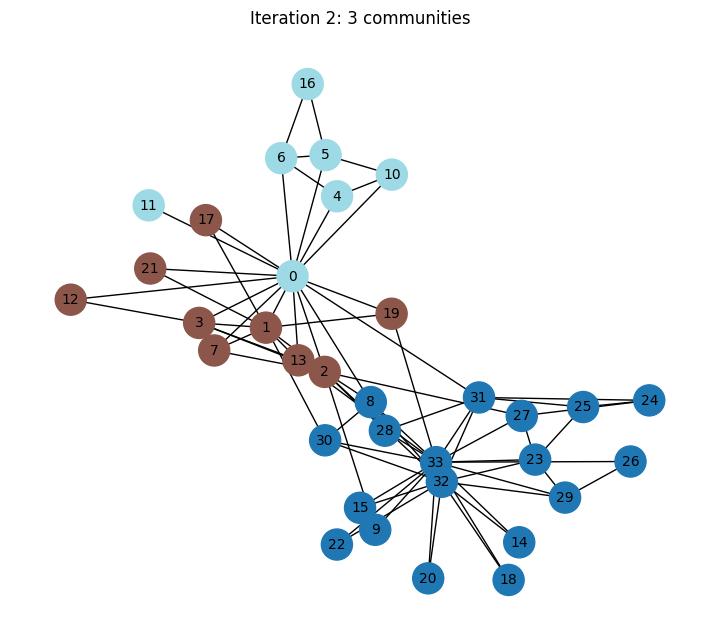

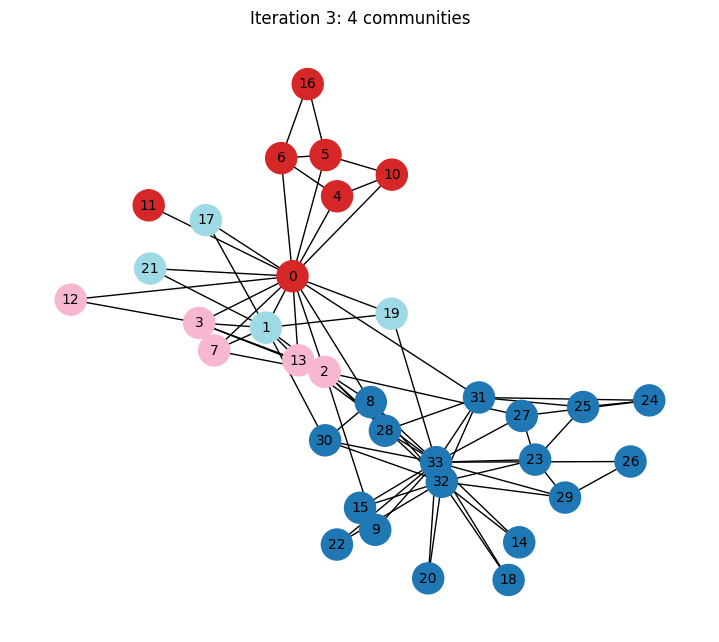

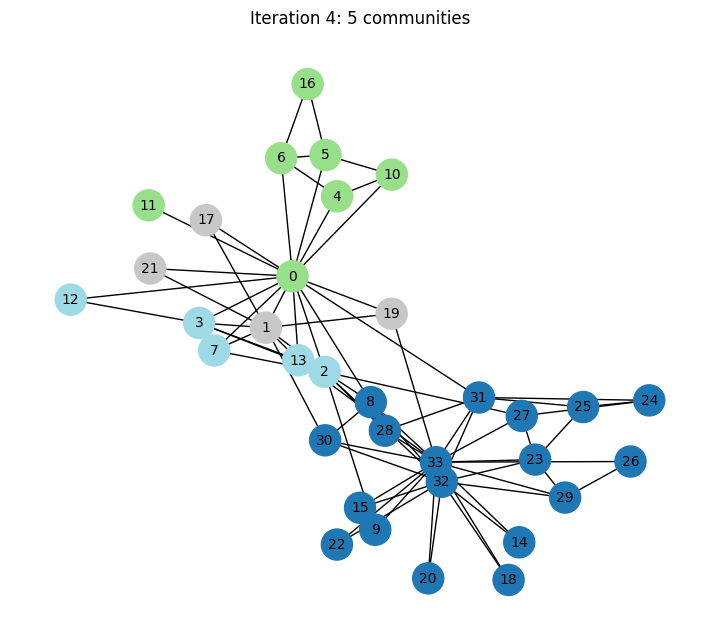

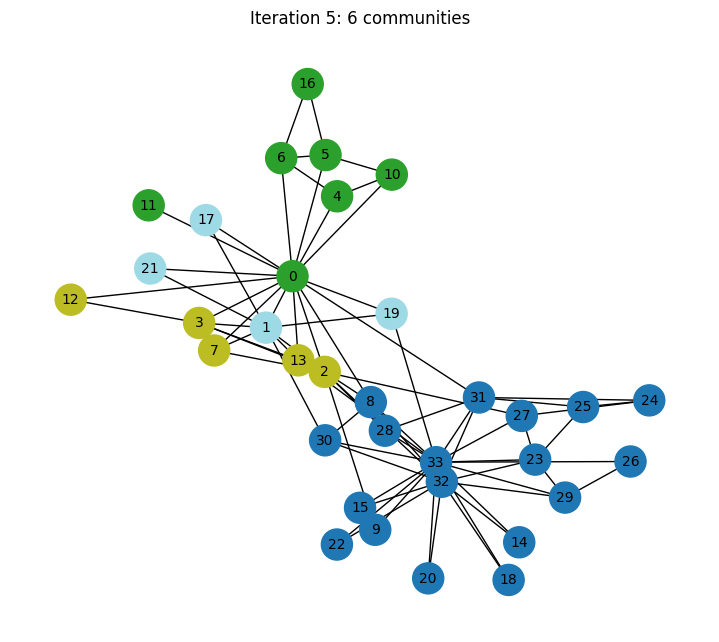

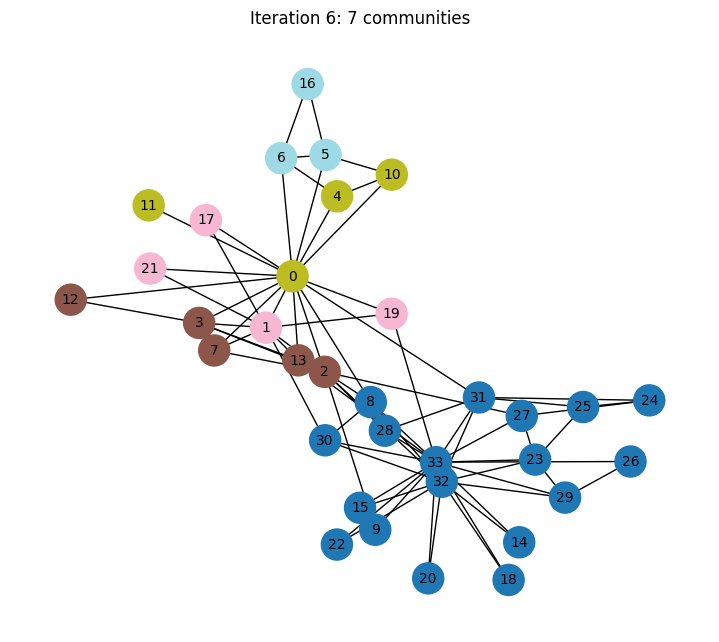

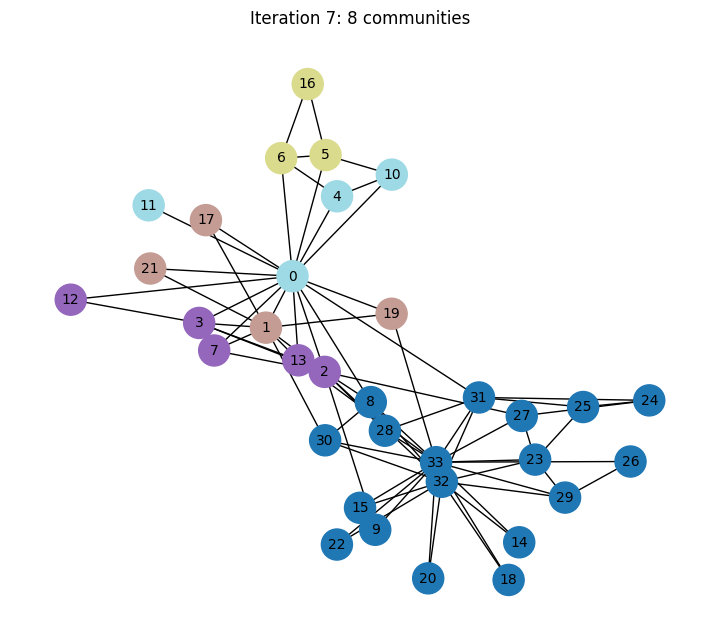

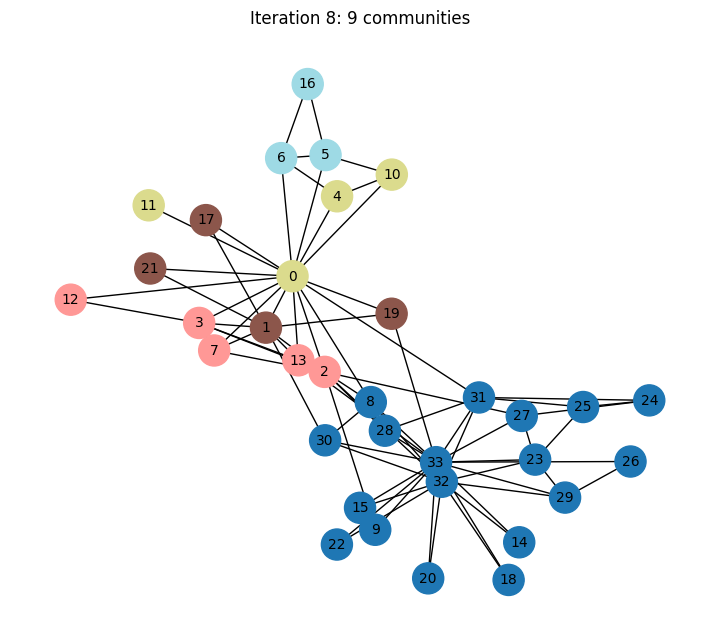

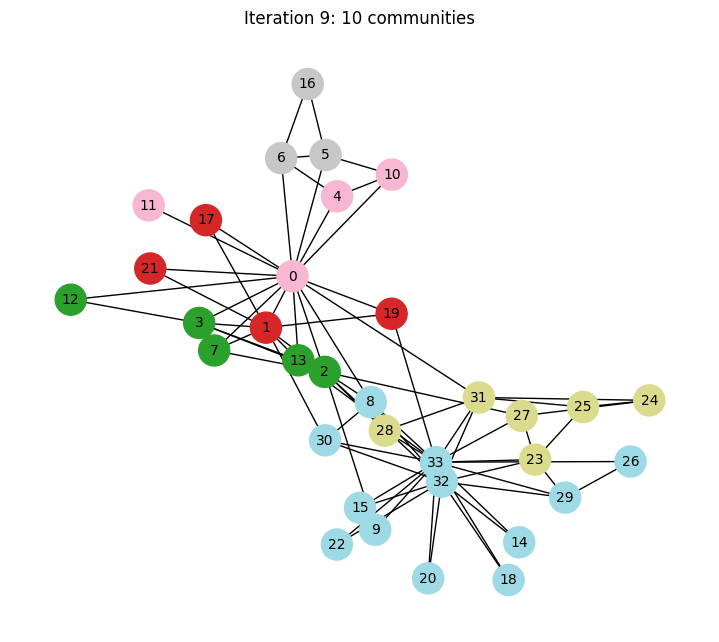

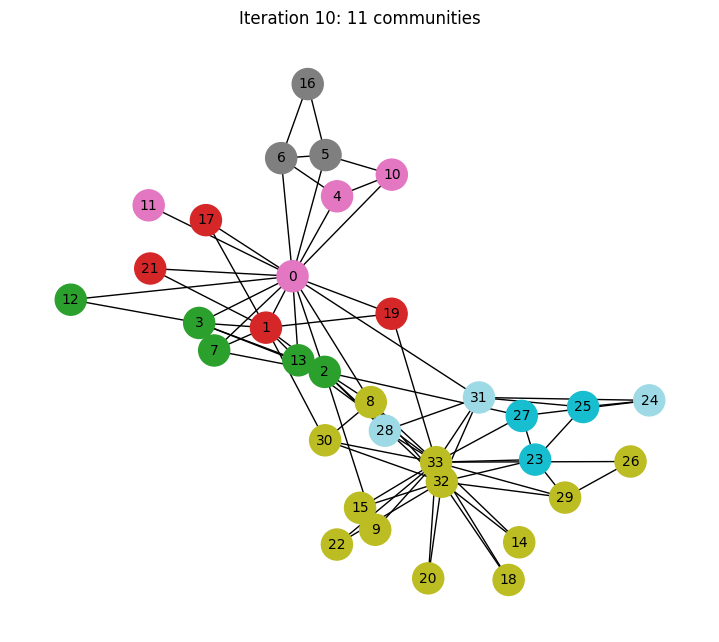

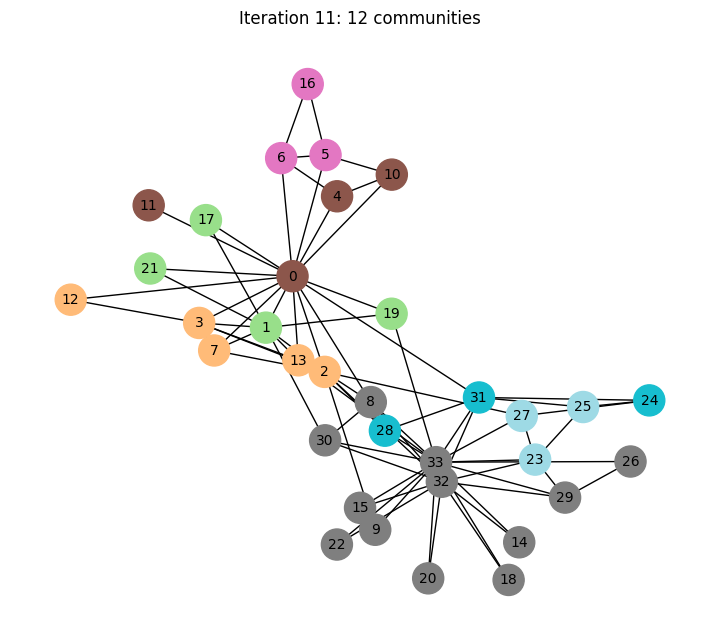

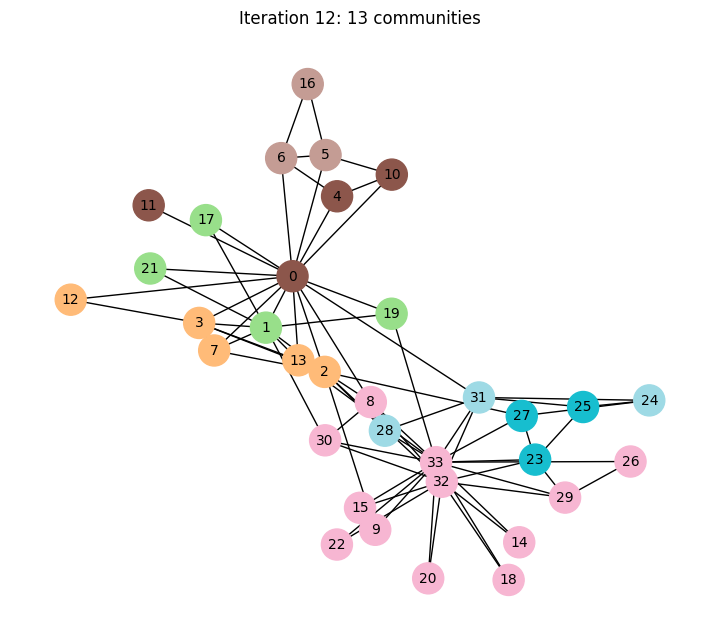

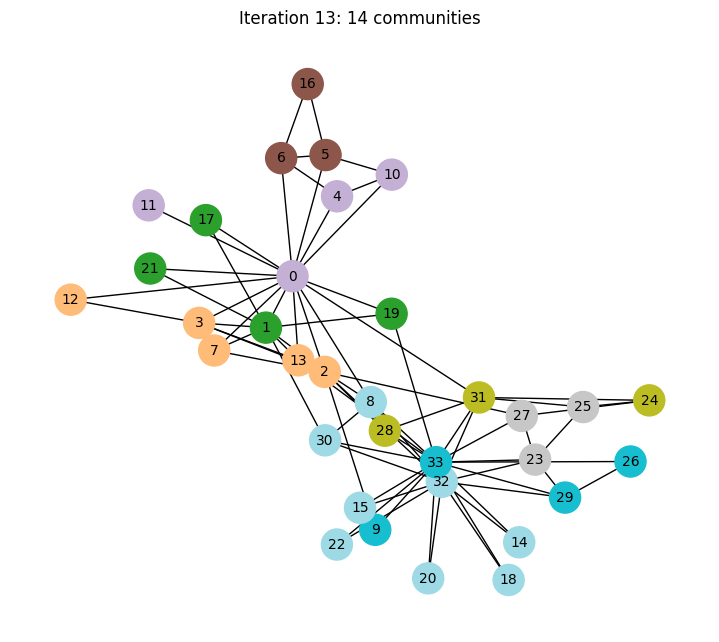

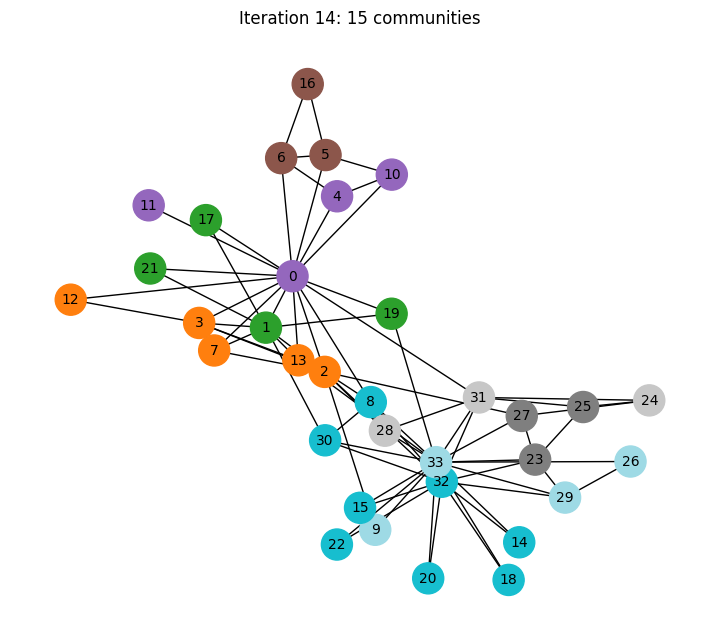

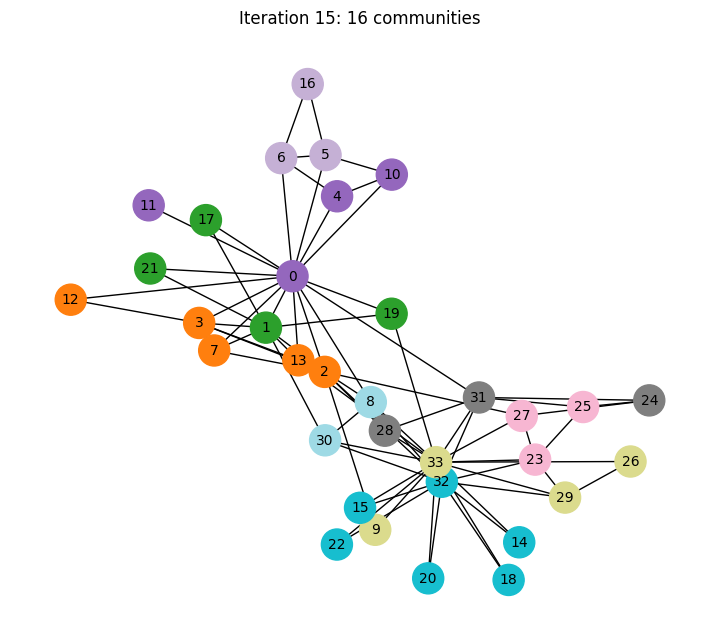

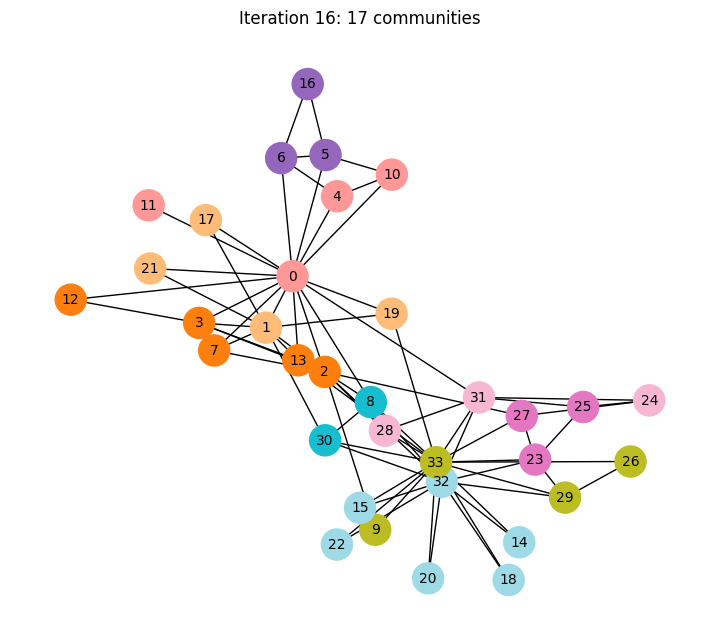

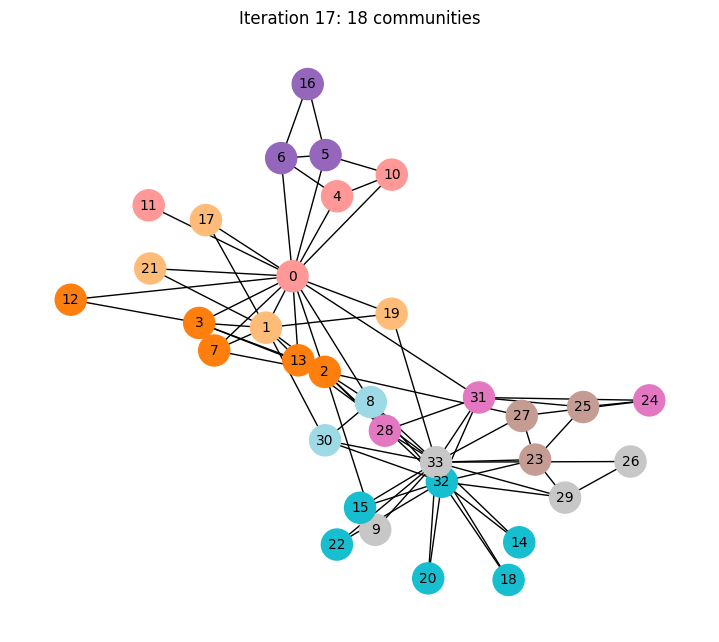

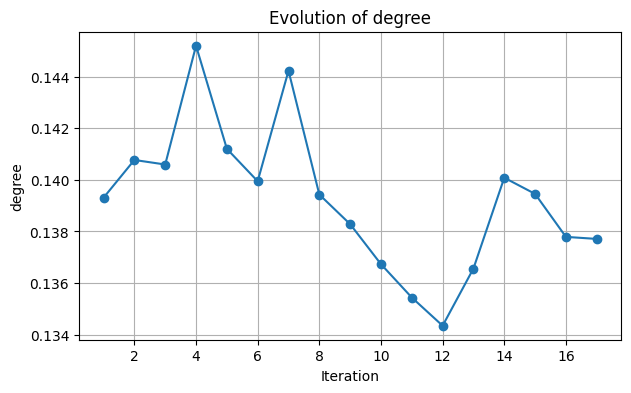

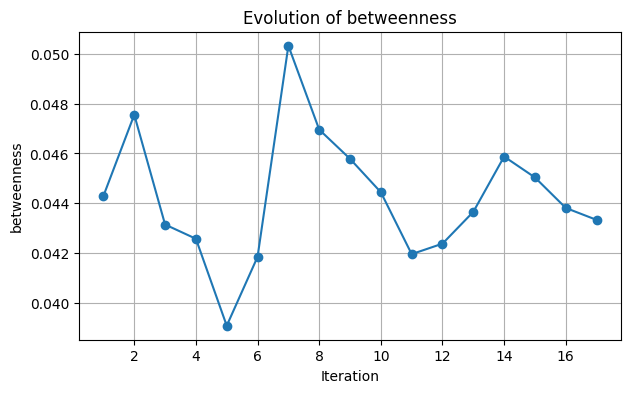

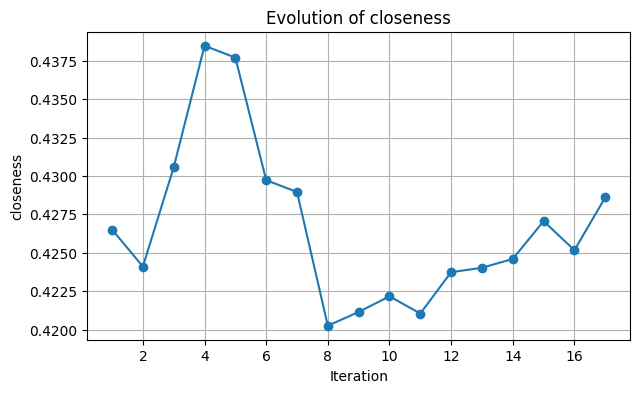

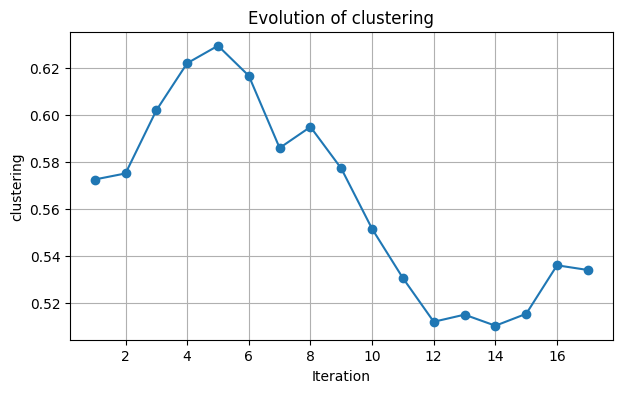

In [7]:
# Load Karate Club Graph
Graph = nx.karate_club_graph()

# recursive partitioning
final_parts, history = recursive_partition(Graph)

# compute metrics
metrics_over_time = compute_metrics(Graph, history)

# position fixed for consistent visualization
pos = nx.spring_layout(Graph, seed=42)

# plot graph after each iteration
for i, parts in enumerate(history):
    plot_partition(Graph, parts, f"Iteration {i+1}: {len(parts)} communities", pos)

# plot degree metrics (degree, betweenness, closeness, clustering)
for metric in ["degree", "betweenness", "closeness", "clustering"]:
    plot_metric(metric)